In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Fontconfig warning: ignoring UTF-8: not a valid region tag


# Training kNN
For kNN training first 225 digits of pi and some extra for LO detection were taken. The Font on Libre Link Up is Source Sans 3

Code inspired by https://stackoverflow.com/questions/9413216/simple-digit-recognition-ocr-in-opencv-python

training complete


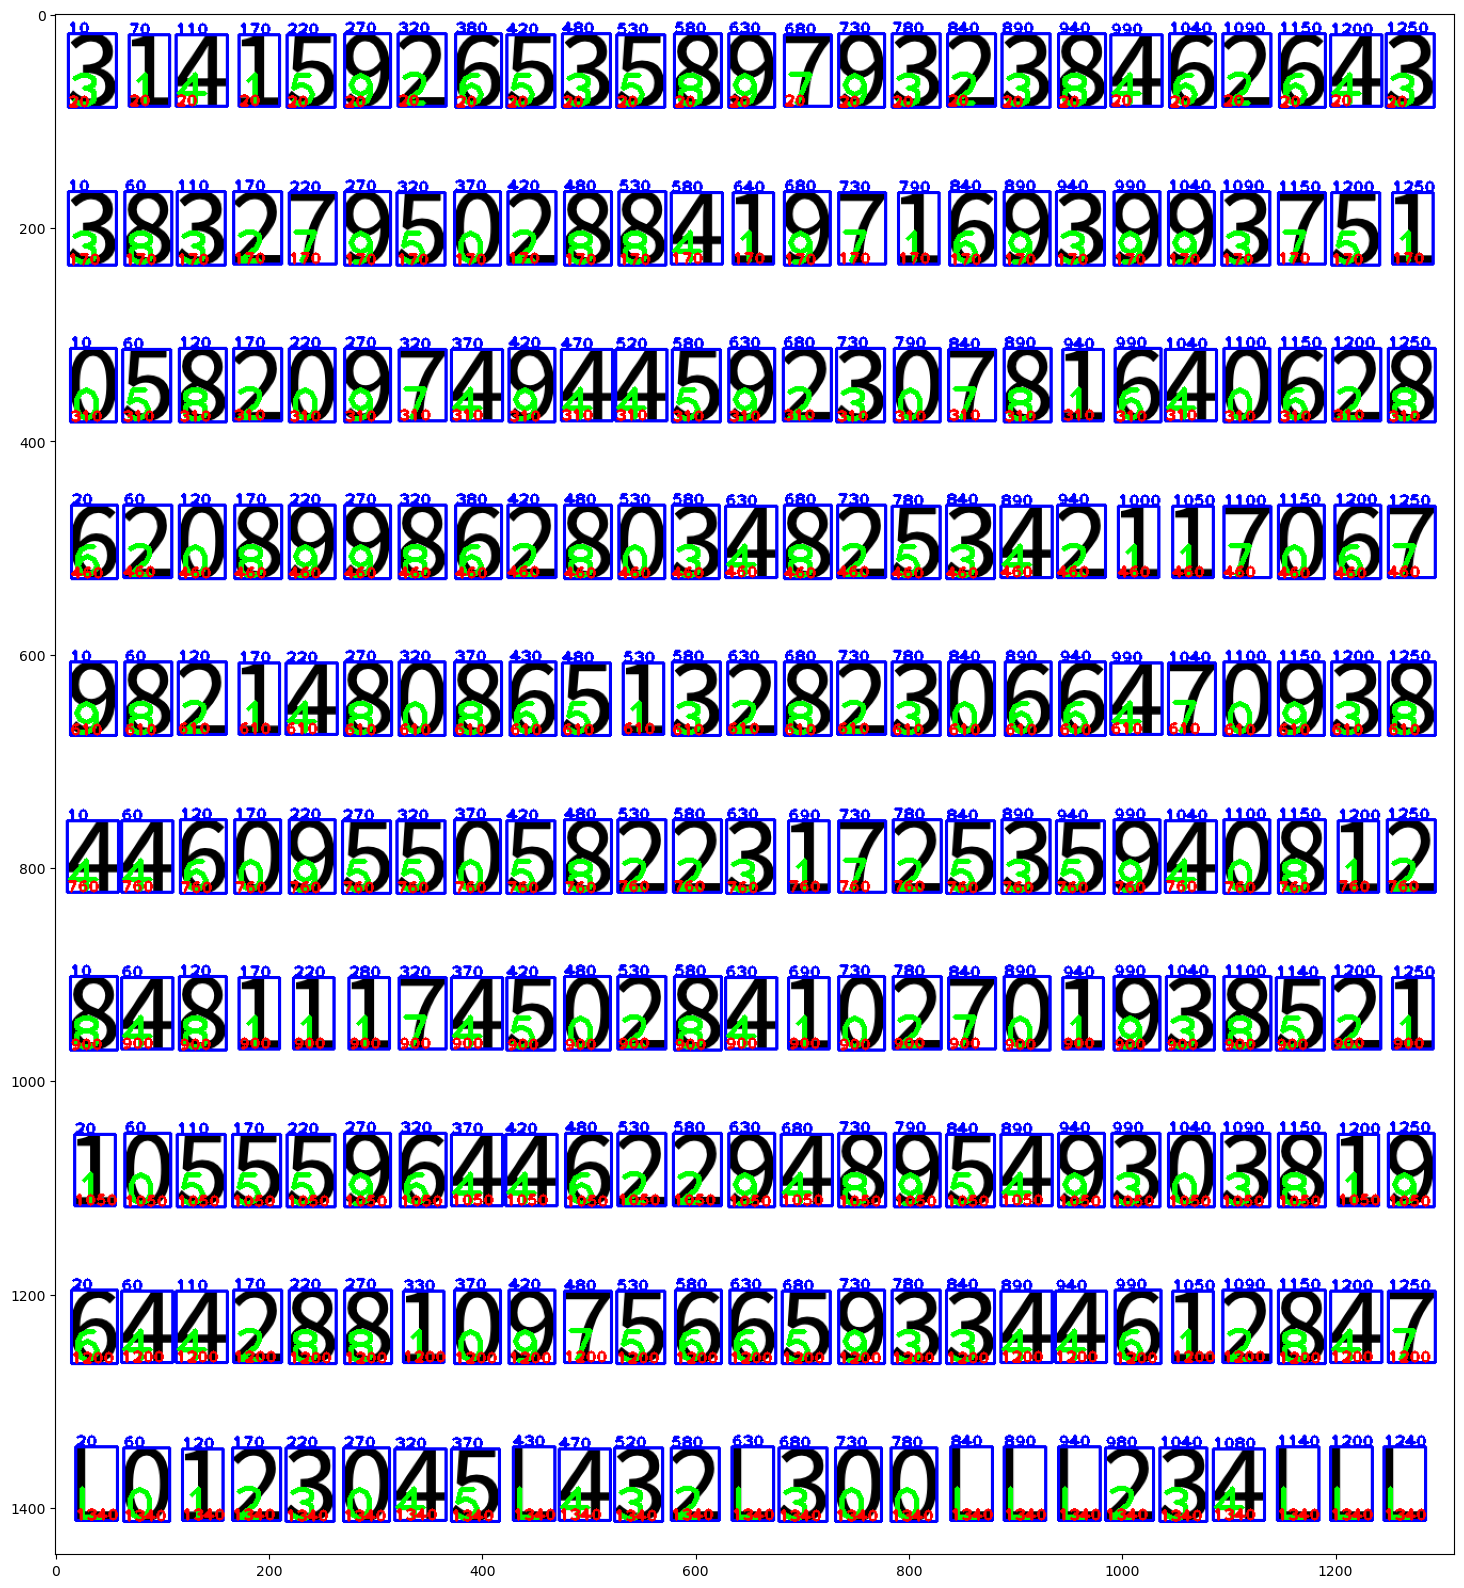

In [11]:
im = cv2.imread('train.png')
im3 = im.copy()

gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(5,5),0)
thresh = cv2.adaptiveThreshold(blur,255,1,1,11,2)

#################      Now finding Contours         ###################

_, contours, _ = cv2.findContours(thresh,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours
bounding_rects = []
sorted_contrours = []

for cnt in contours:
    bounding_rects.append(cv2.boundingRect(cnt))

bounding_rects.sort(key = lambda x: (round(x[1],-1), round(x[0],-1)))



samples =  np.empty((0,225))
chars = list('314159265358979323846264338327950288419716939937510582097494459230781640628620899862803482534211706798214808651328230664709384460955058223172535940812848111745028410270193852110555964462294895493038196442881097566593344612847L0123045L432L300LLL234LLL')
chars_dictionary = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9,
    'L': 10
}
responses = []


for idx, br in enumerate(bounding_rects):
    [x,y,w,h] = br
    
    im = cv2.rectangle(im,(x,y),(x+w,y+h),(0,0,255),2)
    im = cv2.putText(im,chars[idx],(x,y+h),1,3,(0,255,0),3)
    im = cv2.putText(im,f"{round(x,-1)}",(x,y),1,1,(0,0,255),2)
    im = cv2.putText(im,f"{round(y,-1)}",(x,y+h),1,1,(255,0,0),2)
    roi = thresh[y:y+h,x:x+w]
    roismall = cv2.resize(roi,(15,15))
    responses.append(int(chars_dictionary[chars[idx]]))
    
    sample = roismall.reshape((1,225))
    samples = np.append(samples,sample,0)

responses = np.array(responses,np.float32)
responses = responses.reshape((responses.size,1))
print("training complete")

plt.figure(figsize=(20,20))
plt.imshow(im)
plt.show()
np.savetxt('generalsamples.data',samples)
np.savetxt('generalresponses.data',responses)


### Check labels

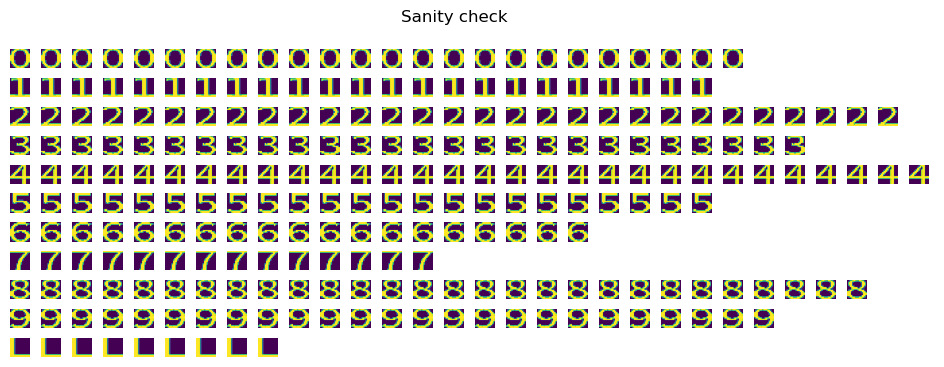

In [12]:
rows = 11 # number of classes
columns = chars.count(max(set(chars), key=chars.count)) # most common element count

fig, axs = plt.subplots(rows, columns, figsize=(12, 4))
fig.subplots_adjust(hspace = .5, wspace=.001)

indicies = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
dict = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'L'
    }


for i in indicies:
    current_count = 0

    for j, char in enumerate(chars):
        if char == dict[i]:
            axs[i][current_count].imshow(samples[j].reshape((15,15)))
            current_count += 1
        if j < columns:
            axs[i][j].axis('off')

fig.suptitle('Sanity check')
plt.show()

### Check model

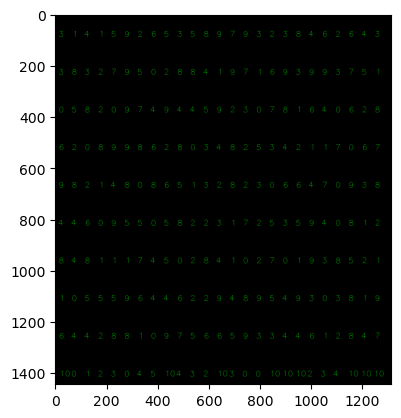

In [15]:
#######   training part    ############### 
samples = np.loadtxt('generalsamples.data',np.float32)
responses = np.loadtxt('generalresponses.data',np.float32)
responses = responses.reshape((responses.size,1))

model = cv2.ml.KNearest_create()
model.train(samples,cv2.ml.ROW_SAMPLE,responses)

############################# testing part  #########################
img = cv2.imread("train.png")
im = img.copy()
out = np.zeros(im.shape,np.uint8)
gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
# thresh = cv2.adaptiveThreshold(gray,255,1,1,11,2)
thresh2 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY_INV)
thresh = cv2.morphologyEx(thresh2[1], cv2.MORPH_OPEN, (5,5))

_,contours,_ = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

for cnt in contours:
    [x,y,w,h] = cv2.boundingRect(cnt)
    cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)
    roi = thresh[y:y+h,x:x+w]
    roismall = cv2.resize(roi,(15,15))
    roismall = roismall.reshape((1,225))
    roismall = np.float32(roismall)
    retval, results, neigh_resp, dists = model.findNearest(roismall, k = 1)
    string = str(int((results[0][0])))
    cv2.putText(out,string,(x,y+h),0,1,(0,255,0))

plt.imshow(out)

### Check camera